In [1]:
import scipy.signal as ss
import numpy as np
import matplotlib.pyplot as plt

# IIR filtering

This tutorial covers practical aspects of IIR (Infinite Impulse Response) filtering. The theoretical and background aspects are covered [here](https://en.wikipedia.org/wiki/Infinite_impulse_response).

### Test signal

Consider pure random noise with a DC offset as a test signal for filtering.

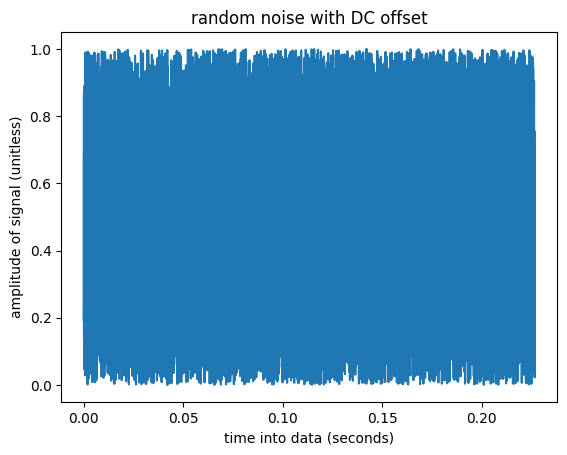

In [2]:
n_sample = 10000
fs = 44100  # sample rate in Hz
data = np.random.random(n_sample)
plt.plot(np.arange(n_sample) / fs, data)
plt.xlabel("time into data (seconds)")
plt.ylabel("amplitude of signal (unitless)")
_ = plt.title("random noise with DC offset")

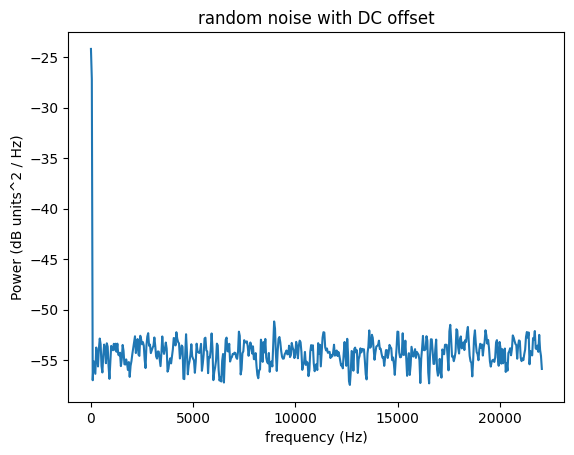

In [3]:
# note the use of density so that the noise floor is independent of FFT parasm
freqs, Pxx = ss.welch(data, fs, "hanning", nperseg=1024, noverlap=512, detrend=False, scaling="density")
plt.plot(freqs, 10 * np.log10(Pxx))
plt.xlabel("frequency (Hz)")
plt.ylabel("Power (dB units^2 / Hz)")
_ = plt.title("random noise with DC offset")

### Filter design

There are a multitude of filter design methods (including FIR filters), which usually come down to a trade-off between pass band ripple, stop band attenuation, steepness of filter roll-off, and linearity of phase response. See [here](https://www.mathworks.com/help/signal/ug/iir-filter-design.html) for a list of IIR filters. In this analysis, we will use Butterworth filters, which have a minimal pass band ripple. All IIR filters in `scipy.signal` use the same interface.

#### Band pass filtering

In [4]:
bandpass_low_hz = 5000
bandpass_high_hz = 10000
b, a = ss.butter(3, [bandpass_low_hz / (fs /2), bandpass_high_hz / (fs /2)], btype="bandpass") 

In [5]:
filt_data = ss.lfilter(b, a, data)

Since the data outside of the bandpass filter has been attenuated, the DC offset has been suppressed. The data that was i.i.d. samples now has noticeable temporal correlations between adjacent samples.

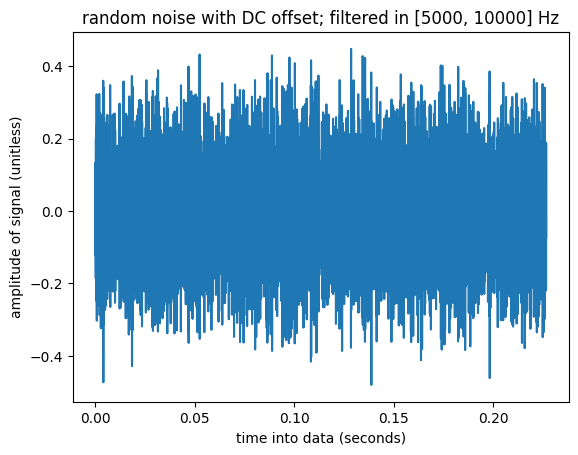

In [6]:
plt.plot(np.arange(n_sample) / fs, filt_data)
plt.xlabel("time into data (seconds)")
plt.ylabel("amplitude of signal (unitless)")
_ = plt.title(f"random noise with DC offset; filtered in {[bandpass_low_hz, bandpass_high_hz]} Hz")

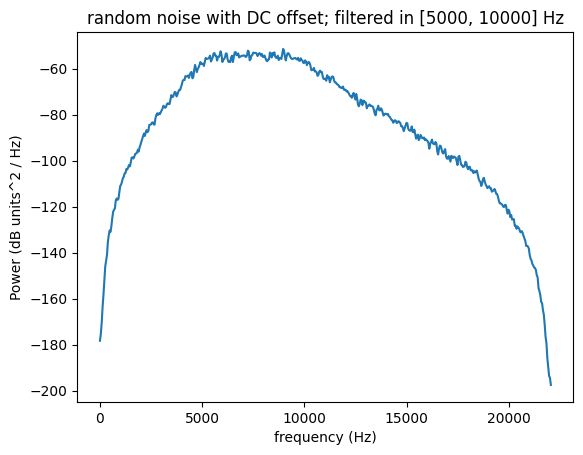

In [7]:
freqs, Pxx = ss.welch(filt_data, fs, "hanning", nperseg=1024, noverlap=512, detrend=False, scaling="density")
plt.plot(freqs, 10 * np.log10(Pxx))
plt.xlabel("frequency (Hz)")
plt.ylabel("Power (dB units^2 / Hz)")
_ = plt.title(f"random noise with DC offset; filtered in {[bandpass_low_hz, bandpass_high_hz]} Hz")

Applying the filter on random noise allows one to see the filter response. One can also see the filter response by applying the filter to a Kronecker delta.

In [8]:
kronecker_delta = np.zeros(n_sample)
kronecker_delta[50] = 1
filt_kronecker_delta = ss.lfilter(b, a, kronecker_delta)

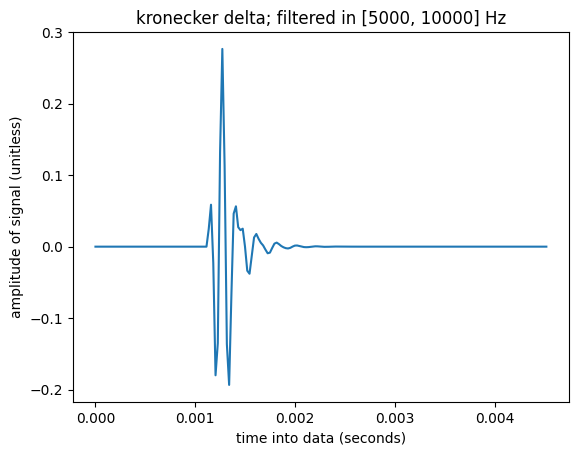

In [9]:
plt.plot(np.arange(200) / fs, filt_kronecker_delta[:200])
plt.xlabel("time into data (seconds)")
plt.ylabel("amplitude of signal (unitless)")
_ = plt.title(f"kronecker delta; filtered in {[bandpass_low_hz, bandpass_high_hz]} Hz")

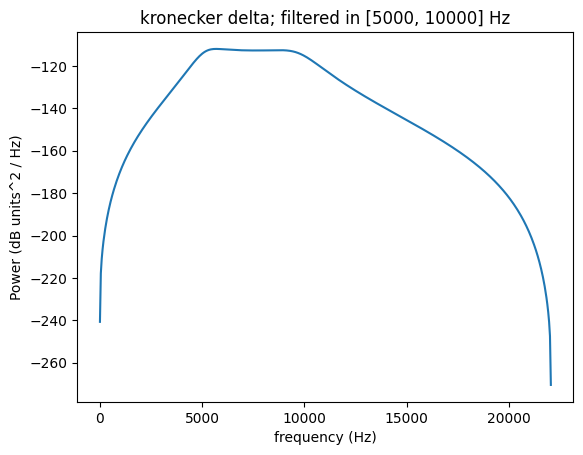

In [10]:
freqs, Pxx = ss.welch(filt_kronecker_delta, fs, "hanning", nperseg=1024, noverlap=512, detrend=False, scaling="density")
plt.plot(freqs, 10 * np.log10(Pxx))
plt.xlabel("frequency (Hz)")
plt.ylabel("Power (dB units^2 / Hz)")
_ = plt.title(f"kronecker delta; filtered in {[bandpass_low_hz, bandpass_high_hz]} Hz")

#### High pass filtering

One can also construct a high-pass filter. This is useful for removing DC components.

In [11]:
b, a = ss.butter(3, 1.0 / 1000.0, btype="high") 
filt_data = ss.lfilter(b, a, data)

Notice the 'filter pop' at the beginning of the data whilst the IIR filter 'settles'. If one is not worried about online operation (or wishes to remove the non-linear phase response), one can use a `filtfilt` rather than a `lfilter` to perform forward and backward passes of the IIR filter.

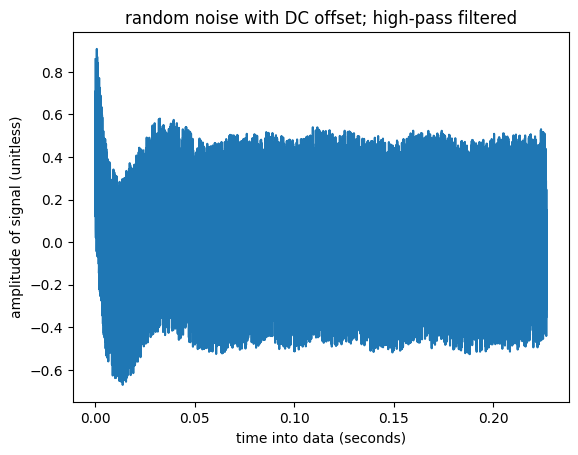

In [12]:
plt.plot(np.arange(n_sample) / fs, filt_data)
plt.xlabel("time into data (seconds)")
plt.ylabel("amplitude of signal (unitless)")
_ = plt.title(f"random noise with DC offset; high-pass filtered")

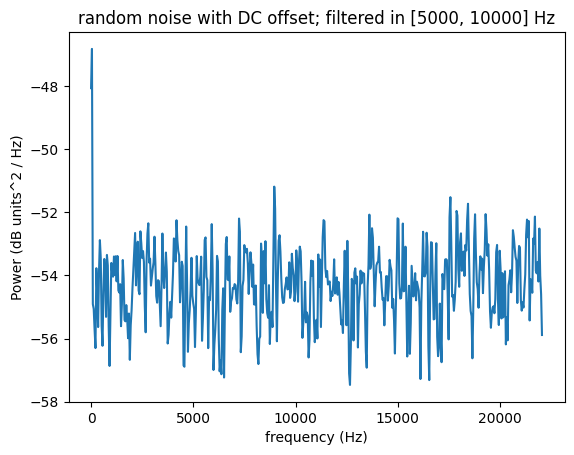

In [13]:
freqs, Pxx = ss.welch(filt_data, fs, "hanning", nperseg=1024, noverlap=512, detrend=False, scaling="density")
plt.plot(freqs, 10 * np.log10(Pxx))
plt.xlabel("frequency (Hz)")
plt.ylabel("Power (dB units^2 / Hz)")
_ = plt.title(f"random noise with DC offset; filtered in {[bandpass_low_hz, bandpass_high_hz]} Hz")

#### Filter stability

Since IIR filters use recently filtered samples to influence newly filtered samples, there is a risk of the filter becoming 'unstable', or 'divergent'. There is a rich theory of this occurring due to the filter becoming 'non-causal', which can be described by the poles and zeros of the filter as derived from the filter's Z-transform, as described [here](https://brianmcfee.net/dstbook-site/content/ch12-ztransform/PoleZero.html). In practice, for a designed filter that is unstable, the poles tend to have magnitude _almost_ 1.0, but not quite; the actual stability gets lost in the floating point noise of the magnitude of the pole which is _almost_ 1.

A practical way of assessing filter stability is to apply the filter to random noise, and see if the output diverges.

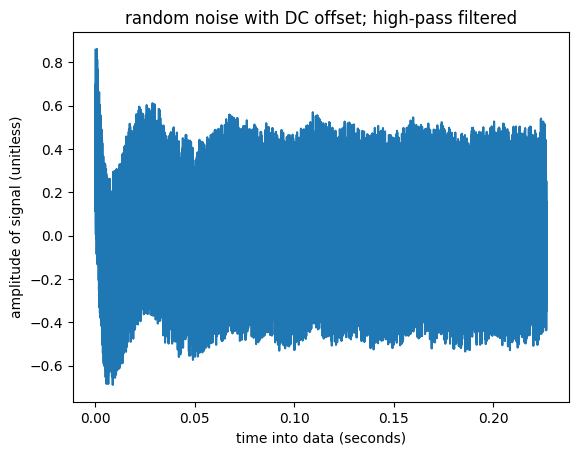

In [14]:
b, a = ss.butter(5, 1.0 / 1000.0, btype="high") 

plt.plot(np.arange(n_sample) / fs, ss.lfilter(b, a, data))
plt.xlabel("time into data (seconds)")
plt.ylabel("amplitude of signal (unitless)")
_ = plt.title(f"random noise with DC offset; high-pass filtered")

In the case below, the fractional bandwidth requested for the filter design is too tight for an order 5 filter to be stable.

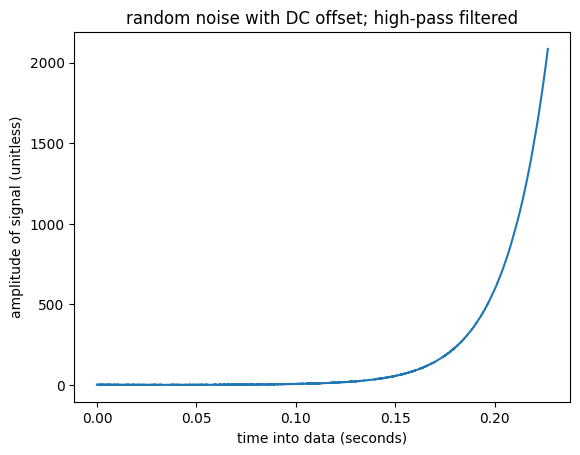

In [15]:
b, a = ss.butter(5, 1.0 / 10000.0, btype="high")
filt_data = ss.lfilter(b, a, data)

plt.plot(np.arange(n_sample) / fs, filt_data)
plt.xlabel("time into data (seconds)")
plt.ylabel("amplitude of signal (unitless)")
_ = plt.title(f"random noise with DC offset; high-pass filtered")